This is a project for implementing the factorization method for structure from motion

Authors: Pupei Zhu pzhu13@jhu.edu, Zhiwei Gong zgong9@jhu.edu

Date: 2022-12-14

In [ ]:
import numpy as np
import cv2 as cv

## Set parameters for feature detection and tracking

In [2]:
feature_params = dict(maxCorners=5000, qualityLevel=0.01, minDistance=3, blockSize=7)

lk_params = dict(winSize=(40, 40), maxLevel=3, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 30, 0.01))

color = np.random.randint(0,255,(100,3))

## SFM for medusa

In [3]:
data_path = './Data/medusa.dv'
cap = cv.VideoCapture(data_path)

# If the video is not found
while not cap.isOpened():
    cap = cv.VideoCapture(data_path)
    cv.waitKey(1000)
    print("Wait for the header")

# Read the first frame and use goodFeaturesToTrack
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
features = []
counter = 0
indexes = []

# Optical flow
# Since some of the frames is not friendly for tracking features, we use frame 100 to 260 for calculation
while cap.isOpened():
    ret, frame = cap.read()
    if counter < 100:
        counter += 1
        continue
    counter += 1
    if ret is False or counter > 260:
        break
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select features that are good
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    features.append(p1)
    indexes.append(st)
    
    cv.imshow('frame',frame)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Update
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()
cap.release()

In [4]:
print("The number of frames: ", len(features))

The number of frames:  160


## Discard features that are missing

In [5]:
features_new = []
good_p = []
for i in range(len(indexes)):
    p_temp = features[i]
    for j in range(i,len(indexes)):
        st_temp = indexes[j]
        good_p = p_temp[st_temp == 1]
        p_temp = good_p.reshape(-1, 1, 2)
    features_new.append(good_p)

## Using factorization method in the paper

### Calculate W matrix and W_hat matrix

In [6]:
R = len(features_new)
C = len(features_new[0])
W = np.zeros([2*R, C])
for i in range(R):
    for j in range(C):
        W[i][j] = features_new[i][j][0]
        W[R+i][j] = features_new[i][j][1]

In [7]:
W_hat = W - W.mean(axis=1).reshape(-1,1)

### Calculate R_hat, S_hat

In [8]:
U, s, Vh = np.linalg.svd(W_hat)
print(U.shape, s.shape, Vh.shape)
# Select U, Vh with largest three eigen values
U_large = U[:,0:3]
Vh_large = Vh[0:3,:]
R_hat = U_large @ np.diag(np.sqrt(s[:3]))
S_hat = np.diag(np.sqrt(s[:3])) @ Vh_large
print(R_hat.shape)
print(S_hat.shape)

(320, 320) (320,) (4005, 4005)
(320, 3)
(3, 4005)


### Using cholesky decompozation to solve metric constraint

In [9]:
Frame_number = R_hat.shape[0]//2
print(Frame_number)

160


In [10]:
def SolveMetricConst(Frame_number, R_hat):
    R_i = R_hat[:Frame_number, :]
    R_j = R_hat[Frame_number:2*Frame_number, :]
    tmp = np.zeros((2*Frame_number, 6))
    for i in range(Frame_number):
        tmp[2 * i, 0] = (R_i[i, 0] ** 2) - (R_j[i, 0] ** 2)
        tmp[2 * i + 1, 0] = R_i[i, 0] * R_j[i, 0]
        tmp[2 * i, 1] = 2 * ((R_i[i, 0] * R_i[i, 1]) - (R_j[i, 0] * R_j[i, 1]))
        tmp[2 * i + 1, 1] = R_i[i, 1] * R_j[i, 0] + R_i[i, 0] * R_j[i, 1]
        tmp[2 * i, 2] = 2 * ((R_i[i, 0] * R_i[i, 2]) - (R_j[i, 0] * R_j[i, 2]))
        tmp[2 * i + 1, 2] = R_i[i, 2] * R_j[i, 0] + R_i[i, 0] * R_j[i, 2]
        tmp[2 * i, 3] = (R_i[i, 1] ** 2) - (R_j[i, 1] ** 2)
        tmp[2 * i + 1, 3] = R_i[i, 1] * R_j[i, 1]
        tmp[2 * i, 5] = (R_i[i, 2] ** 2) - (R_j[i, 2] ** 2)
        tmp[2 * i + 1, 4] = R_i[i, 2] * R_j[i, 1] + R_i[i, 1] * R_j[i, 2]
        tmp[2 * i, 4] = 2 * ((R_i[i, 2] * R_i[i, 1]) - (R_j[i, 2] * R_j[i, 1])) 
        tmp[2 * i + 1, 5] = R_i[i, 2] * R_j[i, 2]

    tmpU, tmpS, tmpVh = np.linalg.svd(tmp)
    Q_sqr = np.zeros((3,3))
    tmpV = tmpVh[-1,:]
    Q_sqr[0, 0] = tmpV[0]
    Q_sqr[0, 1] = tmpV[1]
    Q_sqr[1, 0] = tmpV[1]
    Q_sqr[0, 2] = tmpV[2]
    Q_sqr[2, 0] = tmpV[2]
    Q_sqr[1, 1] = tmpV[3]
    Q_sqr[2, 1] = tmpV[4]
    Q_sqr[1, 2] = tmpV[4]
    Q_sqr[2, 2] = tmpV[5]  
    
    Q_sqr = np.abs(Q_sqr)
    Q = np.linalg.cholesky(Q_sqr)
    return Q

In [11]:
Q = SolveMetricConst(Frame_number, R_hat)
R = R_hat @ Q
S = np.linalg.inv(Q) @ S_hat

## Plot the 3D features

<IPython.core.display.Javascript object>


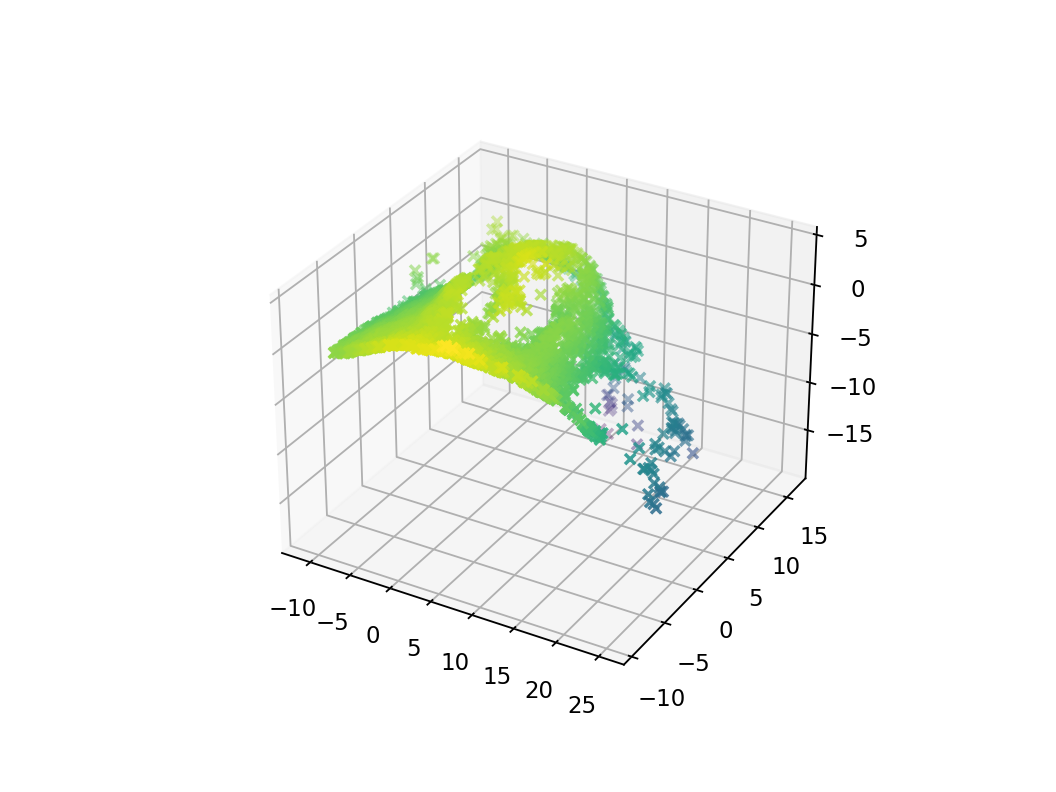

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook

first_2000 = S[0, :]
second_2000 = S[1, :]
third_2000 = S[2, :]

pointcloud = np.zeros((first_2000.shape[0], 3))
pointcloud[:, 0] = first_2000
pointcloud[:, 1] = second_2000
pointcloud[:, 2] = third_2000

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(pointcloud[:, 0],   # x
           pointcloud[:, 1],   # y
           pointcloud[:, 2],   # z
           c=pointcloud[:, 2], # height data for color,
           marker="x")

<IPython.core.display.Javascript object>


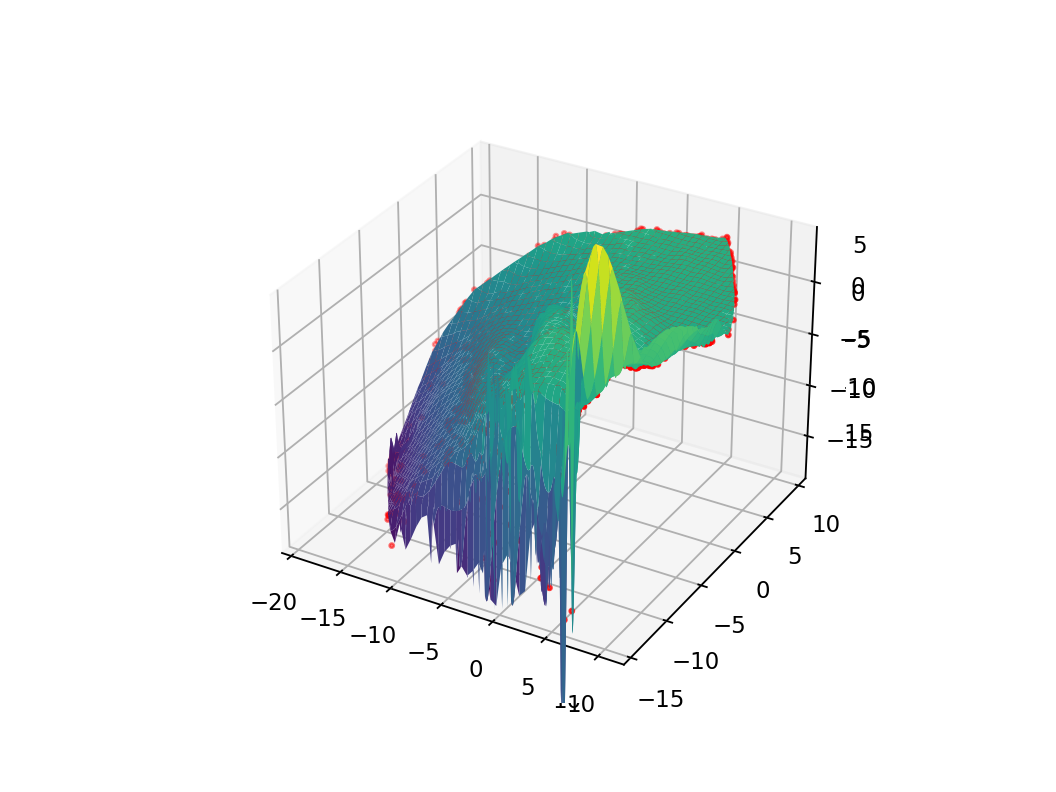

In [13]:
# Align the first camera reference system with the world reference system


# Calculate the number of frames
F = 160

# Normalize the first and last rows of R
i1 = np.transpose(R[0,:])
i1 = i1 / np.linalg.norm(i1)

j1 = np.transpose(R[F,:])
j1 = j1 / np.linalg.norm(j1)

# Calculate the cross product of i1 and j1
k1 = np.cross(i1, j1)
k1 = k1 / np.linalg.norm(k1)

# Create the rotation matrix R0
R0 = np.array([i1, j1, k1])

# Transform R and S using R0
R = np.dot(R, R0)
S = np.dot(np.linalg.inv(R0), S)



import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Create a figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot a scatter plot
ax.scatter(S[0,:], S[1,:], S[2,:], '*')

# Create the x and y data for the grid
xlin = np.linspace(min(S[0,:]), max(S[0,:]), 500)
ylin = np.linspace(min(S[1,:]), max(S[1,:]), 500)
X, Y = np.meshgrid(xlin, ylin)

# Interpolate the Z data using cubic interpolation
Z = griddata((S[0,:], S[1,:]), S[2,:], (X, Y), method='cubic')

# Create the surface plot
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Adjust the axes and plot
ax.set_xlim(min(S[0,:]), max(S[0,:]))
ax.set_ylim(min(S[1,:]), max(S[1,:]))
ax.set_zlim(min(S[2,:]), max(S[2,:]))

# Add a scatter plot of the original data
ax.scatter3D(S[0,:], S[1,:], S[2,:], c='r', marker='.', s=15)

# Show the plot
plt.show()


## SFM for castle

## Parameter setting

In [14]:
feature_params = dict(maxCorners=5000, qualityLevel=0.01, minDistance=3, blockSize=7)

lk_params = dict(winSize=(40, 40), maxLevel=3, criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 30, 0.01))

color = np.random.randint(0,255,(100,3))

## Optical Flow

In [15]:
data_path = './Data/castlejpg/castle.0'
img = cv.imread(data_path+'00.jpg')

# Read the first frame and use goodFeaturesToTrack
old_frame = img
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask=None, **feature_params)
features = []
indexes = []

# Optical flow
for i in range(1, 28):
    if i < 10:
        n = '0'+str(i)
    else:
        n = str(i)
    frame = cv.imread(data_path+n+'.jpg')
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    # Calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)
    # Select features that are good
    good_new = p1[st == 1]
    good_old = p0[st == 1]
    features.append(p1)
    indexes.append(st)
    
    cv.imshow('frame',frame)
    k = cv.waitKey(30) & 0xff
    if k == 27:
        break

    # Update
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1, 1, 2)

cv.destroyAllWindows()
cap.release()

## Discard features that are missing

In [16]:
features_new = []
good_p = []
for i in range(len(indexes)):
    p_temp = features[i]
    for j in range(i,len(indexes)):
        st_temp = indexes[j]
        good_p = p_temp[st_temp == 1]
        p_temp = good_p.reshape(-1, 1, 2)
    features_new.append(good_p)

## Using factorization method in the paper

### Calculate W matrix and W_hat matrix

In [17]:
R = len(features_new)
C = len(features_new[0])
W = np.zeros([2*R, C])
for i in range(R):
    for j in range(C):
        W[i][j] = features_new[i][j][0]
        W[R+i][j] = features_new[i][j][1]

In [18]:
W_hat = W - W.mean(axis=1).reshape(-1,1)

### Calculate R_hat, S_hat

In [19]:
U, s, Vh = np.linalg.svd(W_hat)
print(U.shape, s.shape, Vh.shape)
# Select U, Vh with largest three eigen values
U_large = U[:,0:3]
Vh_large = Vh[0:3,:]
R_hat = U_large @ np.diag(np.sqrt(s[:3]))
S_hat = np.diag(np.sqrt(s[:3])) @ Vh_large
print(R_hat.shape)
print(S_hat.shape)

(54, 54) (54,) (3598, 3598)
(54, 3)
(3, 3598)


### Using cholesky decompozation to solve metric constraint

In [20]:
Frame_number = R_hat.shape[0]//2
print(Frame_number)

27


In [21]:
Q = SolveMetricConst(Frame_number, R_hat)
R = R_hat @ Q
S = np.linalg.inv(Q) @ S_hat

<IPython.core.display.Javascript object>


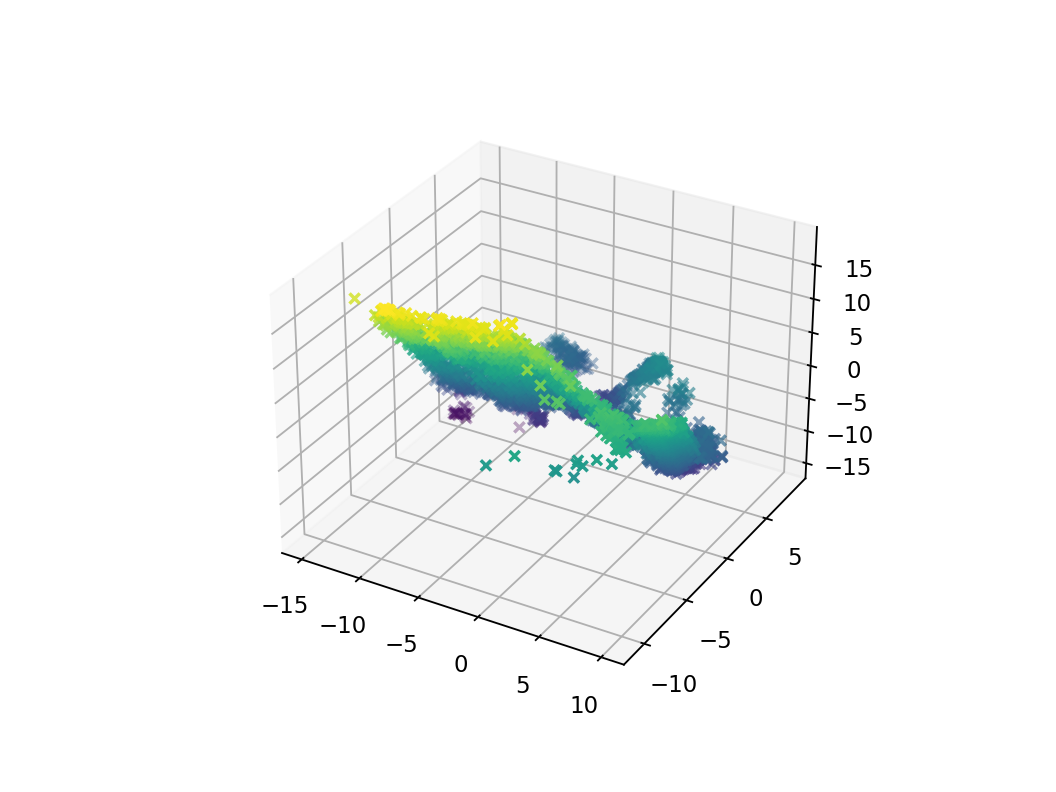

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook

first_2000 = S[0, :]
second_2000 = S[1, :]
third_2000 = S[2, :]

pointcloud = np.zeros((first_2000.shape[0], 3))
pointcloud[:, 0] = first_2000
pointcloud[:, 1] = second_2000
pointcloud[:, 2] = third_2000

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
pnt3d = ax.scatter(pointcloud[:, 0],   # x
           pointcloud[:, 1],   # y
           pointcloud[:, 2],   # z
           c=pointcloud[:, 2], # height data for color,
           marker="x")

<IPython.core.display.Javascript object>


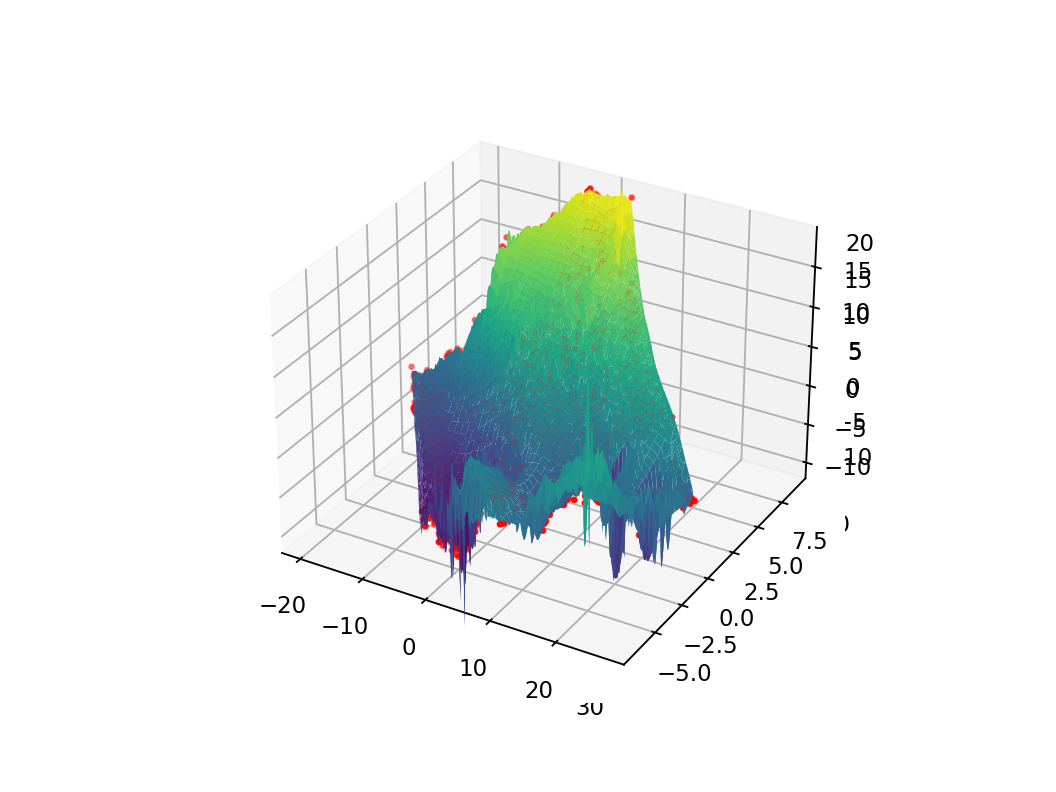

In [23]:
# Align the first camera reference system with the world reference system


# Calculate the number of frames
F = 27

# Normalize the first and last rows of R
i1 = np.transpose(R[0,:])
i1 = i1 / np.linalg.norm(i1)

j1 = np.transpose(R[F,:])
j1 = j1 / np.linalg.norm(j1)

# Calculate the cross product of i1 and j1
k1 = np.cross(i1, j1)
k1 = k1 / np.linalg.norm(k1)

# Create the rotation matrix R0
R0 = np.array([i1, j1, k1])

# Transform R and S using R0
R = np.dot(R, R0)
S = np.dot(np.linalg.inv(R0), S)



import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Create a figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot a scatter plot
ax.scatter(S[0,:], S[1,:], S[2,:], '*')

# Create the x and y data for the grid
xlin = np.linspace(min(S[0,:]), max(S[0,:]), 500)
ylin = np.linspace(min(S[1,:]), max(S[1,:]), 500)
X, Y = np.meshgrid(xlin, ylin)

# Interpolate the Z data using cubic interpolation
Z = griddata((S[0,:], S[1,:]), S[2,:], (X, Y), method='cubic')

# Create the surface plot
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

# Adjust the axes and plot
ax.set_xlim(min(S[0,:]), max(S[0,:]))
ax.set_ylim(min(S[1,:]), max(S[1,:]))
ax.set_zlim(min(S[2,:]), max(S[2,:]))

# Add a scatter plot of the original data
ax.scatter3D(S[0,:], S[1,:], S[2,:], c='r', marker='.', s=15)

# Show the plot
plt.show()
